In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import sparse
import json
from datetime import datetime
import warnings

import pcg_skel
from cloudvolume import CloudVolume
from caveclient import CAVEclient

### pre-synaptic cell type:

In [ ]:
pre_type = "23P"

In [2]:
euc_dist_step = 100 * 1000  # bin width for euclidean distance based histograms
path_dist_step = 100 * 1000  # bin width for path-length based histograms
rad_dist_step = 25 * 1000
nsteps = 1000
cache_dir = "..\\data\\"
trash = True  # adds a "trash" label to the folder of results so I know I don't care about them
max_hist_dist = 2_000_000
num_syns_cutoff = 100
split_quality_cutoff = 0.5
require_in_col = False  # this requires the pre- and post-synaptic cells to be in the proofread column, in which all cells were manually cell-typed
allow_clean = True  # whether to allow clean neurons, as opposed to thoroughly proofread "extended" axon
from_first_branch_pt = False  # count path distance starting from the first branch point (for exc cells) as opposed to soma
inh_cell_types = ["BPC", "BC", "MC", "NGC"]

datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [3]:
# client.auth.get_new_token()  # <-- use this the first time to get a token
# client.auth.save_token( )

## Find a presynaptic cell of type `pre_type` that's been proofread to investigate

In [5]:
all_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id
cells_by_nuc = all_cells.copy()
cells_by_nuc.index = cells_by_nuc.id

In [6]:
# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

col_cells = all_cells[all_cells.pt_position.apply(in_bbox)]

In [7]:
# use this cell if you want to go through the cells one at a time
# gather a list of thoroughly proofread layer 2/3 pyramidal cells
proofreading_status = client.materialize.query_table('proofreading_status_public_release')
proofread_cells = proofreading_status.query(f"(status_axon == 'extended' or (status_axon == 'clean' and {allow_clean})) and valid_id == pt_root_id")
pre_type_cells = all_cells.query(f"cell_type == '{pre_type}'")
root_ids_to_study = list(set.intersection(set(pre_type_cells.pt_root_id.unique()), set(proofread_cells.valid_id.unique())))
if require_in_col:
    root_ids_to_study = list(set.intersection(set(root_ids_to_study), col_cells.pt_root_id.unique()))
nucs_to_study = list(cells_by_root.id.loc[root_ids_to_study].values)  # permanent nucleus id of cell
print(len(root_ids_to_study), len(nucs_to_study))
if len(root_ids_to_study) != len(nucs_to_study):
    raise ValueError("Some cells were not proofread properly")

77 77


In [8]:
nuc_id = nucs_to_study.pop()  # look at the next thoroughly proofread pre-synaptic cell
cell_root_id = cells_by_nuc.pt_root_id.loc[nuc_id]
cell_root_id, nuc_id, nucs_to_study

(864691135771901947,
 520182,
 [553407,
  258307,
  487512,
  610396,
  518623,
  583741,
  610535,
  554775,
  608213,
  580774,
  582056,
  554900,
  551802,
  612352,
  516758,
  583792,
  518224,
  581967,
  259167,
  581998,
  610434,
  582210,
  518004,
  582390,
  518312,
  519746,
  327859,
  518853,
  584004,
  520027,
  553469,
  582412,
  582353,
  582294,
  582313,
  553585,
  582444,
  518848,
  292713,
  581988,
  553283,
  554833,
  516621,
  583848,
  580988,
  580826,
  553321,
  518752,
  553216,
  580905,
  582129,
  223037,
  582011,
  610403,
  580948,
  517056,
  582471,
  518898,
  518134,
  583729,
  608166,
  553556,
  553339,
  553589,
  583739,
  553325,
  582468,
  582409,
  582388,
  582414,
  518632,
  555010,
  493968,
  553360,
  554734,
  610615])

In [8]:
# cells_str = ",\n".join(map(str, nucs_to_study))
# with open(os.path.join(cache_dir, "cells.txt"), "w") as f:
#     f.write(cells_str)

In [9]:
# # run this command to run this notebook for all cells in cells_str (make sure the above two cells are commented out)
# # for /l %x in (1, 1, 40) do jupyter nbconvert --to notebook --execute --inplace synapse_analysis.ipynb
# with open(os.path.join(cache_dir, "cells.txt"), "r") as f:  # cells.txt is just a list of the 20 proofread cells above
#     nucs_to_study = list(map(int, f.read().split(",\n")))

# nuc_id = nucs_to_study.pop()  # look at the next thoroughly proofread layer 2/3 pyramidal cell
# cell_root_id = cells_by_nuc.pt_root_id.loc[nuc_id]
# cells_str = ",\n".join(map(str, nucs_to_study))
# print(cell_root_id, nuc_id)
# with open(os.path.join(cache_dir, "cells.txt"), "w") as f:  
#     f.write(cells_str)

864691135293126156 258307


In [9]:
cell_data = all_cells.query(f"pt_root_id == {cell_root_id}")
root_point = cell_data['pt_position'].iloc[0]
cell_data

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,num_soma
45041,520182,t,aibs_coarse_excitatory,23P,107040137762348606,864691135771901947,"[307744, 130080, 20953]",1


### Set up storage of results

In [10]:
results_dict = {"parameters": {"pre_type": pre_type, "split_quality_cutoff": split_quality_cutoff, "num_syns_cutoff": num_syns_cutoff, "nsteps": nsteps, "max_hist_dist": max_hist_dist, "euc_dist_step": euc_dist_step, "path_dist_step": path_dist_step, "rad_dist_step": rad_dist_step, "require_in_col": require_in_col}}
results_fname = str(nuc_id) + "_" + str(datetime.now()).replace(" ", "_").replace(":", ".")
clean_status = "clean" if allow_clean else "extended"
col_status = "-col" if require_in_col else ""
trash_status = "-trash" if trash else ""
from_branch_status = "-branch" if from_first_branch_pt else ""
results_dir = os.path.join(cache_dir, "results", f"{pre_type}-{clean_status}-subclass{col_status}{from_branch_status}{trash_status}")
results_path = os.path.join(results_dir, results_fname + ".json")

In [11]:
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)
    os.mkdir(os.path.join(results_dir, "cumulative"))

## Get the neuron

In [12]:
nrn_cache_dir = os.path.join(cache_dir, "nrns")
try:
    print("Loading neuron from cache...", end="")
    nrn = pcg_skel.meshwork.load_meshwork(os.path.join(nrn_cache_dir, str(nuc_id) + '.h5'))
    print(" successful.")
except FileNotFoundError as e:
    print(" cached skeleton not found. Generating skeleton.")
    print("\t", e)
    nrn = pcg_skel.pcg_meshwork(
                    cell_root_id,
                    client=client,
                    root_point=root_point,
                    root_point_resolution=[4, 4, 40],
                    collapse_soma=True,
                    invalidation_d=3,
                    synapse_table='synapses_pni_2',
                    synapses="all",
                    refine='all',
                    cache=os.path.join(cache_dir, "l2lookup.sqlite"),
                    save_to_cache=True
                )
    nrn.save_meshwork(os.path.join(nrn_cache_dir, str(nuc_id) + '.h5'))

# find the synapses on the axon
is_axon, split_quality = pcg_skel.meshwork.algorithms.split_axon_by_synapses(
    nrn, nrn.anno.pre_syn.skel_index, nrn.anno.post_syn.skel_index
)
nrn.anno.add_annotations("is_axon", is_axon, mask=True)
if split_quality < split_quality_cutoff:
    raise ValueError(f"Axon may not have been found. Split quality: {split_quality}")
split_quality

Loading neuron from cache... successful.


0.8080220500187779

In [13]:
output_df = nrn.anno.pre_syn.df
output_df["skel_idx"] = nrn.anno.pre_syn.mesh_index.to_skel_index_padded  # maps to the index of the nearest skeleton vertex
output_df = output_df[nrn.anno.is_axon.mesh_mask[output_df.pre_pt_mesh_ind]] # only look at synapses on the axon, because those on the dendrites are mislabelled

## Clean the data further

In [14]:
roots_with_soma = set(cells_by_root.index)

In [15]:
# not falsely merged
#                   root_id is of a cell       and there is only 1 soma associated with it
include = np.array([root_id in roots_with_soma and type(cells_by_root.id.loc[root_id]) == np.int64 for root_id in output_df.post_pt_root_id])
if require_in_col:
    # in column
    col_root_ids = set(col_cells.pt_root_id.values)
    include &= np.array([c in col_root_ids for c in output_df.post_pt_root_id])
# other possible criteria: proofread, in one of the other tables

# finally filter by the above criteria
clean_output_df = output_df[include].copy()
# and add a column with the permanent nucleu ID of the post-syn cell
clean_output_df["post_pt_nuc_id"] = [cells_by_root.loc[r].id for r in clean_output_df.post_pt_root_id]

if len(clean_output_df.post_pt_root_id) < num_syns_cutoff and not require_in_col:  # skip if there are unreasonably few clean connections
    raise ValueError("Not enough clean synapses")

In [16]:
# convert to json serializable format (converts np.int64 to int and np.array to list)
clean_output_df = pd.read_json(clean_output_df.to_json())

# Count its synapse types

In [17]:
# # Look at a pyramidal neuron, count its synapse types
def get_prop_type(target_cells, cell_type):
    # target cells are intentionally not necessarily unique
    cell_types = cells_by_root.cell_type.loc[target_cells]
    print("n =", len(cell_types))
    return sum(cell_types.values == cell_type) / len(cell_types) if len(cell_types) > 0 else np.nan

for cell_type in inh_cell_types:
    p = get_prop_type(target_cells=clean_output_df.post_pt_root_id, cell_type=cell_type)
    print(f"post syn {cell_type} proportion given pre is {pre_type}:", p)
    results_dict[f"post_syn_{cell_type}_given_pre_{pre_type}"] = {"p": p, "n": len(clean_output_df.post_pt_root_id)}

n = 125
post syn BPC proportion given pre is 23P: 0.056
n = 125
post syn BC proportion given pre is 23P: 0.152
n = 125
post syn MC proportion given pre is 23P: 0.192
n = 125
post syn NGC proportion given pre is 23P: 0.0


## Soma-to-soma distance

In [18]:
def vx_to_nm(p):
    return p * resolution

def soma_to_soma_dist(post_id):
    possible = cells_by_root.loc[post_id]
    if possible.num_soma > 1: # falsely merged cell (shouldn't happen if data is clean)
        print("false merge")
        return np.nan
    if possible.num_soma == 0: 
        print("no nucleus associated with post-synapse")
        return np.nan
    post_loc = vx_to_nm(possible.pt_position)
    return np.sqrt(np.sum((post_loc - soma_loc) ** 2))

soma_loc = vx_to_nm(cell_data.pt_position.iloc[0])
clean_output_df["soma_to_soma_dist"] = clean_output_df.post_pt_root_id.apply(soma_to_soma_dist)
clean_output_df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,skel_idx,post_pt_nuc_id,soma_to_soma_dist
1,"[179214, 215532, 24789]",160462058,"[179172, 215512, 24786]",864691136109057208,89389059662963754,161517022444781758,595,"[179240, 215608, 24791]",864691135771901947,89459428407142962,14644,t,390,303519,585468.167510
2,"[180358, 210292, 23434]",169771262,"[180348, 210214, 23436]",864691135926508244,89599478499644305,161657072537043445,649,"[180302, 210330, 23433]",864691135771901947,89599478499646505,19460,t,416,267291,622567.546857
3,"[195254, 210034, 22158]",189751605,"[195274, 210092, 22155]",864691136236669711,91640103226766893,163697697264501030,817,"[195246, 210006, 22158]",864691135771901947,91640103226769454,6380,t,546,337863,530264.124979
4,"[178228, 216256, 24722]",161387843,"[178174, 216216, 24722]",864691135383115755,89248390894002038,161376353675903191,534,"[178262, 216258, 24725]",864691135771901947,89318759638166110,4912,t,353,303307,559407.353602
7,"[162106, 195490, 25671]",133372231,"[162088, 195474, 25672]",864691135493650116,87064211179574794,159121805217366136,179,"[162146, 195416, 25679]",864691135771901947,87064211179581328,15160,t,106,267626,651692.125053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,"[179818, 210537, 22686]",169001854,"[179802, 210470, 22687]",864691135472222258,89529109688058211,161586703725756723,623,"[179808, 210602, 22689]",864691135771901947,89529109688049728,224,t,402,267317,597808.487166
213,"[177832, 194616, 26513]",162185823,"[177860, 194624, 26517]",864691135385335893,89245504877603397,161303098915029745,485,"[177780, 194588, 26512]",864691135771901947,89245504877595842,5052,t,309,301451,566418.436988
218,"[298392, 140654, 20831]",362724386,"[298470, 140682, 20832]",864691135508707081,105774943475981175,177832537513525983,2042,"[298362, 140672, 20828]",864691135771901947,105774943475976204,29860,t,1321,527100,227719.375372
219,"[310938, 186694, 20816]",387228683,"[310928, 186768, 20809]",864691135291785142,107540346833342197,179597940870873708,4984,"[310916, 186666, 20811]",864691135771901947,107540346833342014,2528,t,2406,531282,321334.334151


# Find the distance from the soma to each synapse (euclidean, then dijkstra)
## Euclidean

In [19]:
ctr_locs = np.stack(clean_output_df.ctr_pt_position.apply(vx_to_nm).values)  # of synapses
clean_output_df["euc_dist"] = np.sqrt(np.sum((ctr_locs - soma_loc.reshape(1, 3))**2, axis=1))

## Radial (ignoring depth)

In [20]:
clean_output_df["rad_dist"] = np.sqrt(np.sum((ctr_locs[:, [0, 2]] - soma_loc.reshape(1, 3)[:, [0, 2]])**2, axis=1))

## Path-length

In [21]:
skel_vertices = nrn.skeleton.vertices
skel_csgraph = nrn.skeleton.csgraph
idx_of_soma = int(nrn.skeleton.root)

# csgraph stands for compressed sparse graph
ds = sparse.csgraph.dijkstra(skel_csgraph,
                             directed=False,
                             indices=idx_of_soma)
if not all(np.isfinite(ds)):
    raise RuntimeError("Dijkstra's algorithm on the skeleton did not find a solution")

In [22]:
if from_first_branch_pt and cell_data.classification_system.iloc[0] == "aibs_coarse_excitatory":
    # find branch point on axon whose distance_to_root is minimum
    is_axon = nrn.anno.is_axon.mesh_mask
    axon_branch_pts = nrn.branch_points[[is_axon[nrn.branch_points[i]] for i in range(len(nrn.branch_points))]]
    axon_branch_pt_dists = nrn.distance_to_root(axon_branch_pts)
    closest_idx = np.argmin(axon_branch_pt_dists)
    initial_axon_seg_length = axon_branch_pt_dists[closest_idx]
    clean_output_df["path_dist"] = ds[clean_output_df.skel_idx] - initial_axon_seg_length
else:
    initial_axon_seg_length = 0  # in effect, used for later calculations
    clean_output_df["path_dist"] = ds[clean_output_df.skel_idx]
    
# clean_output_df but split into the various cell types
syn_dfs = {"exc": clean_output_df[cells_by_root.classification_system.loc[clean_output_df.post_pt_root_id].values == "aibs_coarse_excitatory"]}
for cell_type in inh_cell_types:
    is_type = cells_by_root.cell_type.loc[clean_output_df.post_pt_root_id].values == cell_type
    syn_dfs[cell_type] = clean_output_df[is_type]

unplotted = clean_output_df[clean_output_df["path_dist"] > max_hist_dist]
if len(unplotted) > 0:
    warnings.warn("Some data is not captured by the histogram")
    print(unplotted)

## Results and Figures!

In [23]:
density = False  # whether to use the counts or density for the histogram
path_bin_edges = np.arange(-initial_axon_seg_length, max_hist_dist, path_dist_step)
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
path_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    path_hists[cell_type] = np.histogram(syn_dfs[cell_type].path_dist, bins=path_bin_edges, density=density)[0]

euc_bin_edges = np.arange(-initial_axon_seg_length, max_hist_dist, euc_dist_step)
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
euc_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    euc_hists[cell_type] = np.histogram(syn_dfs[cell_type].euc_dist, bins=euc_bin_edges, density=density)[0]
    
rad_bin_edges = np.arange(-initial_axon_seg_length, max_hist_dist, rad_dist_step)
rad_bin_centers = (rad_bin_edges[1:] + rad_bin_edges[:-1]) / 2
rad_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    rad_hists[cell_type] = np.histogram(syn_dfs[cell_type].rad_dist, bins=rad_bin_edges, density=density)[0]

In [24]:
# contniuously moving bucket to calculate synapse density of each type
# this implementation is a bit slow, but it's not that big a deal
# (I should rather loop over the synapses and increment appropriate counters as I go)
euc_bin_locs = np.linspace(-initial_axon_seg_length + euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
step_size = max_hist_dist / nsteps
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)
rad_bin_locs = np.linspace(rad_dist_step / 2, max_hist_dist - rad_dist_step / 2, nsteps)
euc_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])
path_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])
rad_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])

for i in range(nsteps):
    euc_c = euc_bin_locs[i]
    euc_l = euc_c - euc_dist_step / 2
    euc_r = euc_c + euc_dist_step / 2
    for cell_type in syn_dfs:
        euc_densities[cell_type][i] = sum((euc_l < syn_dfs[cell_type].euc_dist).values & (syn_dfs[cell_type].euc_dist < euc_r).values) / euc_dist_step
    path_c = path_bin_locs[i]
    path_l = path_c - path_dist_step / 2
    path_r = path_c + path_dist_step / 2
    for cell_type in syn_dfs:
        path_densities[cell_type][i] = sum((path_l < syn_dfs[cell_type].path_dist).values & (syn_dfs[cell_type].path_dist < path_r).values) / path_dist_step
    rad_c = rad_bin_locs[i]
    rad_l = rad_c - rad_dist_step / 2
    rad_r = rad_c + rad_dist_step / 2
    for cell_type in syn_dfs:
        rad_densities[cell_type][i] = sum((rad_l < syn_dfs[cell_type].rad_dist).values & (syn_dfs[cell_type].rad_dist < rad_r).values) / rad_dist_step

In [25]:
p_type_by_path_dists = dict()
path_total_density = sum(path_densities[t] for t in path_densities)
for cell_type in path_densities:
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density
p_type_by_euc_dists = dict()
euc_total_density = sum(euc_densities[t] for t in euc_densities)
for cell_type in euc_densities:
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density
p_type_by_rad_dists = dict()
rad_total_density = sum(rad_densities[t] for t in rad_densities)
for cell_type in rad_densities:
    p_type_by_rad_dists[cell_type] = rad_densities[cell_type] / rad_total_density


C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [26]:
def to_dict_list(d):
    """converts a dictionary of np arrays to a dictionary of lists"""
    return {k: d[k].tolist() for k in d}
results_dict["euc_hists"] = to_dict_list(euc_hists)
results_dict["path_hists"] = to_dict_list(path_hists)
results_dict["rad_hists"] = to_dict_list(rad_hists)
results_dict["euc_densities"] = to_dict_list(euc_densities)
results_dict["path_densities"] = to_dict_list(path_densities)
results_dict["rad_densities"] = to_dict_list(rad_densities)
results_dict["p_type_by_path_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["p_type_by_euc_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["p_type_by_rad_dists"] = to_dict_list(p_type_by_rad_dists)
results_dict["clean_output_dict"] = clean_output_df.to_dict()
results_dict["syn_dicts"] = dict((key, syn_dfs[key].to_dict()) for key in syn_dfs)

with open(results_path, "w") as f:
    f.write(json.dumps(results_dict))

In [27]:
plot_colors = ["lime", "darkorchid", "gold", "orangered", "dodgerblue"]
type_colors = dict(zip(syn_dfs.keys(), plot_colors))

In [28]:
import warnings
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

warnings.filterwarnings('ignore')
def get_error_bars(sample_sizes, ps):
    num_successes = np.round(sample_sizes * ps).astype(int)
    # unlike the normal approximation, the wilson method is safe to use for small n and skewed data
    lower, upper = proportion_confint(num_successes, sample_sizes, alpha=0.05, method="wilson")
    return lower, upper

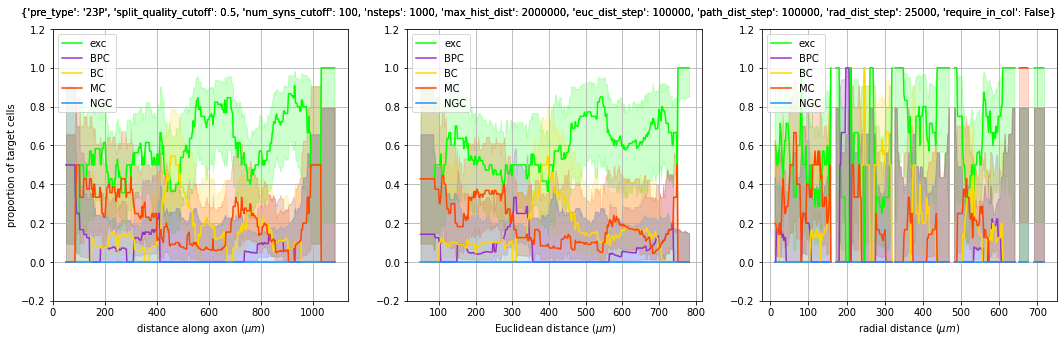

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for cell_type in syn_dfs:
    p = p_type_by_path_dists[cell_type]
    axes[0].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    curr_n = (path_dist_step * path_total_density)
    lower, upper = get_error_bars(curr_n, p)
    axes[0].fill_between(path_bin_locs/1000, lower, upper, color=type_colors[cell_type], alpha=0.2)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("proportion of target cells")
axes[0].legend()
axes[0].grid()
axes[0].set_ylim((-0.2, 1.2))
for cell_type in syn_dfs:
    p = p_type_by_euc_dists[cell_type]
    axes[1].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    curr_n = (path_dist_step * path_total_density)
    lower, upper = get_error_bars(curr_n, p)
    axes[1].fill_between(euc_bin_locs/1000, lower, upper, color=type_colors[cell_type], alpha=0.2)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
axes[1].set_ylim((-0.2, 1.2))
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
for cell_type in syn_dfs:
    p = p_type_by_rad_dists[cell_type]
    axes[2].plot(rad_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    curr_n = (rad_dist_step * rad_total_density)
    lower, upper = get_error_bars(curr_n, p)
    axes[2].fill_between(rad_bin_locs/1000, lower, upper, color=type_colors[cell_type], alpha=0.2)
axes[2].set_xlabel("radial distance ($\mu m$)")
axes[2].legend()
axes[2].grid()
axes[2].set_ylim((-0.2, 1.2))
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [30]:
fig.savefig(os.path.join(results_dir, results_fname + "_p_type.png"))

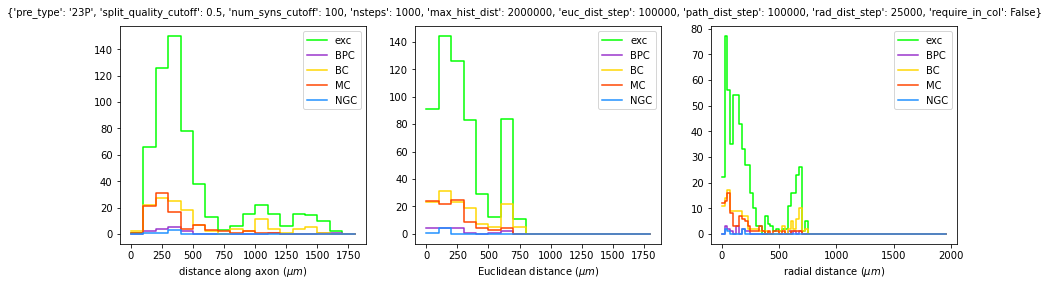

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for cell_type in syn_dfs:
    axes[0].step(path_bin_edges[:-1]/1000, path_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].step(euc_bin_edges[:-1]/1000, euc_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
for cell_type in syn_dfs:
    axes[2].step(rad_bin_edges[:-1]/1000, rad_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[2].set_xlabel("radial distance ($\mu m$)")
axes[2].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [32]:
fig.savefig(os.path.join(results_dir, results_fname + "_hists.png"))

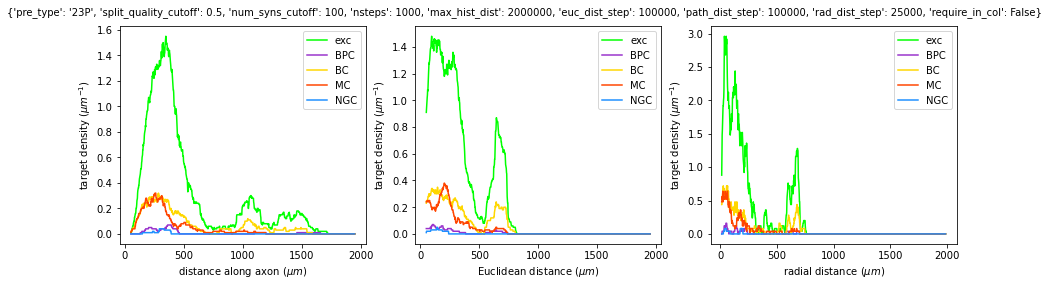

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for cell_type in syn_dfs:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
for cell_type in syn_dfs:
    axes[2].plot(rad_bin_locs/1000, 1000*rad_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[2].set_xlabel("radial distance ($\mu m$)")
axes[2].set_ylabel("target density ($\mu m^{-1}$)")
axes[2].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [34]:
fig.savefig(os.path.join(results_dir, results_fname + "_densities.png"))

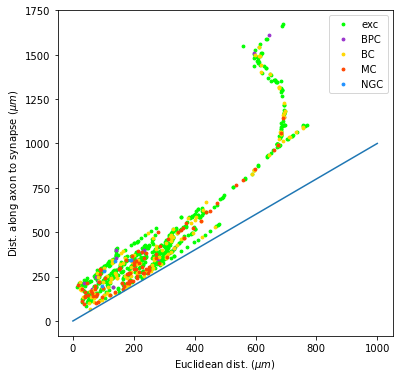

In [35]:
# plot euclidean distance to synapse vs path distance to synapse
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].euc_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.plot([0, 1000], [0, 1000])
ax.set_xlabel("Euclidean dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [36]:
fig.savefig(os.path.join(results_dir, results_fname + "_euc_v_path.png"))

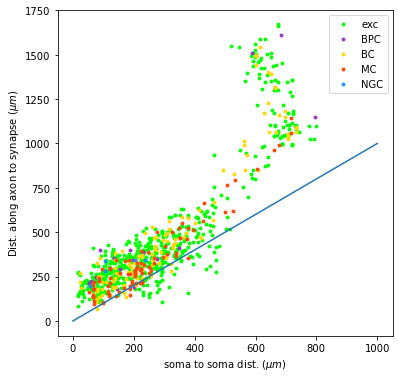

In [37]:
# plot path-distance along axon to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.plot([0, 1000], [0, 1000])
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [38]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_path.png"))

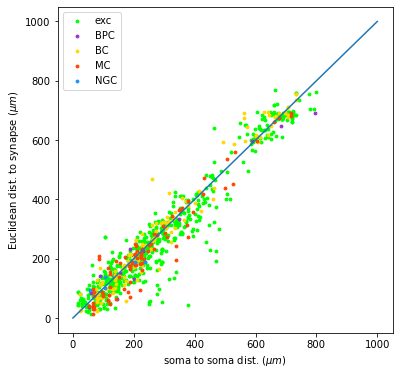

In [39]:
# plot euclidean distance to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].euc_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.plot([0, 1000], [0, 1000])
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Euclidean dist. to synapse ($\mu m$)")
plt.legend()
plt.show()

In [40]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_euc.png"))

In [41]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    pds = syn_dfs[cell_type].path_dist.values / 1000
    eds = syn_dfs[cell_type].euc_dist.values / 1000
    sds = syn_dfs[cell_type].soma_to_soma_dist.values / 1000
    ax.scatter(pds, eds, s=8, c=type_colors[cell_type], label=cell_type)
    ax.scatter(pds, sds, s=20, facecolors="none", edgecolors=type_colors[cell_type])
    for i in range(len(pds)):
        ax.plot([pds[i], pds[i]], [eds[i], sds[i]], alpha=0.5, linewidth=1, color=type_colors[cell_type])
ax.scatter([], [], s=8, color="k", label="synapse")
ax.scatter([], [], s=20, facecolor="none", edgecolors="k", label="post-syn soma")
ax.plot([0, 1000], [0, 1000])
ax.set_ylabel("Euclidean distance ($\mu m$)")
ax.set_xlabel("dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [42]:
fig.savefig(os.path.join(results_dir, results_fname + "_path_v_euc_to_syn_and_soma.png"))

In [43]:
# plot the skeleton
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect(1)
ax.scatter(skel_vertices[:, 0], skel_vertices[:, 1], s=1, alpha=.2, c="lightslategrey", label="neuron skeleton")
for cell_type in syn_dfs:
    syn_locs = syn_dfs[cell_type].pre_pt_position.apply(vx_to_nm).values
    if len(syn_locs) > 0:
        syn_locs = np.stack(syn_locs)
        ax.scatter(syn_locs[:, 0], syn_locs[:, 1], s=8, c=type_colors[cell_type], alpha=1, label=cell_type)
ax.scatter(soma_loc[0], soma_loc[1], s=60, marker="o", facecolors='none', edgecolors='k', label="soma")
ax.invert_yaxis()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [44]:
fig.savefig(os.path.join(results_dir, results_fname + "_skeleton.png"))